# Synthetic Controls: A review

Just as personal review of the process, I will try to make sense of the original Synthetic Control algorithm and of the correction and improvements made by the original author.

Synthetic Control Methods (SCM onwards) is a technique developed to test counterfactuals when there is only information about past observations. The cannonical use case is when, for example, a region-spaning event (natural event, policy, bill, etc) affects one region, while leaving the neighbouring/equivalent region unaffected, and the research would like to estimate the effect of this event over some variable of interest, in comparison with the regions that were not affected, in order to infer causality.

The above implies some rather obvious but still important conditions. First we must have measuments over time of the variable of interest, and this measurements must be equivalent. Second, the units must be comparable. Third, the event must be valid for all the units. This last point is less obvious when the unit is an aggregate of many individuals, but when the unit are individuals (as we will see later) some events are not valid for some units, and hence comparisons between them might not be useful.

In order to undertand this better, I will run a simple example using simulated data. I will follow the notation convention set by [Doudchenko and Inbens (2018)](https://arxiv.org/pdf/1610.07748.pdf). Below I'm simulating the trayectory of a random variable $Y$ for a set $N$ of 500 units $\mathcal{i}$, over periods $t=1,\dots,T$ of 100 time-steps. The simulation was carried out by a simple stochastic process:
$$
Y_{i_{t}} = Y_{i_{t - 1}} + \mathcal{N}(0,1)
$$

Where:
$$
Y_{i_{1}} = \mathcal{Gamma}(2,2)
$$

Meaning that every unit $i$ will have random positive starting point based on a gamma distribution, to later move in random increments around 0 based on a normal distribution.

Additionally, I'm simulating the out variable $Y$ of a treated unit $0$ measured over the same periods $t=1,\dots,T$ of 100 time-steps, but giving it a discontinuity at step $T_{0}=50$ such as $t=1 < T_{0} \leq T$:

$$
Y_{0_{t}} =
\begin{cases}
      Y_{0_{t-1}} + \mathcal{N}(0,1) & \text{if } t \leq 50 \\
      Y_{0_{t-1}} - \mathcal{Gamma}(1,1) & \text{if } t > 50
\end{cases}
$$

Up until the 50th step the random walk should be fairly flat, but from 51th onwards, I'm a subtracting an always positve random number, representing a stark change in the trend. 

For convenience, I will wrap the above math into one single function to call it later:

In [1]:
import random
import math
import pandas as pd
import matplotlib.pyplot as plt

def gen_data(steps, cases):
    X = list(range(1,steps))
    c = []
    for i in range(0, cases):
        y = []
        py = random.gammavariate(2, 2)
        for x in X:
            yi = py + random.gauss(0, 1)
            py = yi
            y.append(yi)
        c.append(y)
    df = pd.DataFrame(c).T
    df.columns = [f'c{x}' for x in range(1, cases+1)]
    t = []
    py = 0
    for i, x in enumerate(X):
        if i <= 50:
            yi = py + random.gauss(0, 1)
            py = yi
        else:
            yi = py - random.gammavariate(1,1)
            py = yi
        t.append(yi)
    T = pd.Series(t)
    df['t'] = T
    return df

As it can seen below, the treated unit is very similar, alotugh slighly below the mean to the other up to the 50th step where it starts to decrease. This point will represent the event in our simulated data.

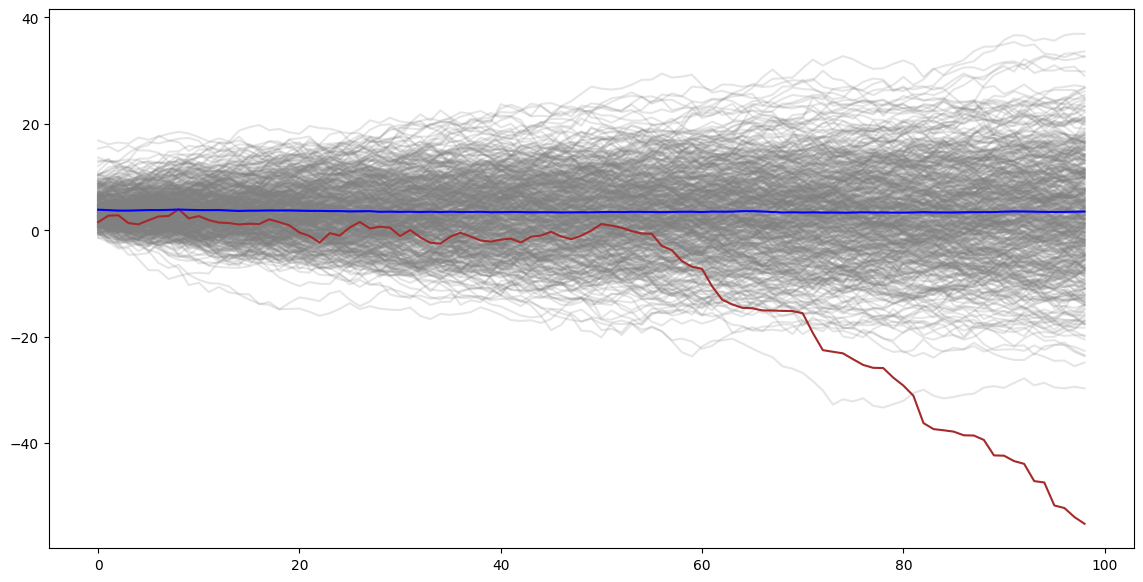

In [3]:
df = gen_data(100, 500)
plt.figure(figsize=(14, 7))
for column in df.drop('t', axis=1):
    plt.plot(df[column], color='grey', alpha=.2)
# highlight treated unit
plt.plot(df['t'], color='brown')
plt.plot(df.drop('t', axis=1).mean(axis=1), color='blue') # lets put the mean also for contrast

In [4]:
df

,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,...,c492,c493,c494,c495,c496,c497,c498,c499,c500,t
0,4.233189,4.509050,3.371949,7.126809,2.449281,6.111304,1.280559,4.977523,5.573017,4.722511,...,4.182205,3.090719,4.726131,2.505067,11.051862,4.768581,-0.553913,3.155069,4.007169,1.539985
1,3.973407,2.584284,1.566305,6.379643,2.436396,5.639278,1.330507,5.251811,6.973617,4.970325,...,3.616012,4.694217,4.054358,2.315566,12.820605,2.543909,-0.867682,2.942054,2.912210,2.741930
2,3.428641,2.160314,2.443897,5.406559,4.084314,5.909438,0.749897,4.172784,6.269801,3.926654,...,4.322545,5.350250,2.182534,0.627074,12.943084,3.701750,-0.281047,3.187852,4.027583,2.823194
3,2.899299,1.688607,3.463213,5.033100,3.541689,6.811054,-0.660382,4.375368,7.521091,4.276127,...,3.521746,4.586337,2.234956,1.861646,14.489730,1.857689,0.205689,2.768286,3.696513,1.359780
4,1.602845,1.688024,3.372362,5.536523,2.049686,6.314629,-0.894568,3.236715,7.621370,5.618533,...,3.000910,4.471442,4.044548,1.401889,15.677657,1.058508,0.454695,3.499552,3.714682,1.113527
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,-19.105779,-11.872976,2.499404,-8.973642,8.477466,0.841821,-13.225926,8.370109,12.582921,12.663138,...,-8.361959,9.353357,0.455888,1.134080,13.686305,4.084723,3.671453,1.574752,1.233021,-47.368724
95,-19.312545,-11.351264,1.604376,-9.244192,10.652724,2.293114,-13.233469,8.243742,11.408478,10.721016,...,-8.908490,9.972339,-0.095883,1.405814,13.505861,2.464997,4.579051,1.046042,0.123954,-51.686155
96,-18.456256,-11.827513,0.871551,-7.477524,9.775015,0.538578,-13.646393,8.368623,10.920384,9.961709,...,-9.734607,8.776141,-0.027701,1.586632,13.428995,1.504677,3.905578,1.075792,0.292779,-52.170623
97,-18.967552,-11.551069,-1.310268,-8.250936,10.213164,0.505784,-12.848087,9.135585,10.623880,10.069681,...,-8.821117,8.392750,-0.613720,2.224950,15.579694,1.686132,4.447161,1.430923,-0.510702,-53.869140


Looking at the above plot its very obvious that our treament had an efect in the variable, but this data datasets its just to ilustrate the inner workings of the technique. The goal of the analysis is to find a suitable twin for our treated unit ${0}$, to later compare the output variable $Y$ of both and measure its difference. In the ideal scenario, we would have parallel universes in which we would measure the output of the treated unit when it was actually treated for every time step: $Y_{0_{t}}(1)$, and the outcome of the same unit in a universe where the treatmet never happened: $Y_{0_{t}}(0)$. Hence the effect of the treatment $\tau$ will be:

$$
\begin{equation}
\tau_{0_{t}} = Y_{0_{t}}(1) - Y_{0_{t}}(0)
\end{equation}
$$


$Y_{0_{t}}(1)$ is observed, for every step $t$, so we don't have to worry about it. But $Y_{0_{t}}(0)$ is not, since accessing parallele universes is currently imposible. So the challenge is to construct $Y_{0_{t}}(0)$ from something else.

Now, the synthetic control method proposed that a weighted sum of similar untreated units might aproximate well to an untreated version of our unit of interest. More formally:

$$
\begin{equation}
\hat{Y}_{0_{t}}(0) = \mu + \sum^{N}_{i=1}\omega_{i} \cdot Y_{i_{t}}
\end{equation}
$$

Meaning that a series of weights $\omega$ for every control units, multiplied to the value of $Y$ of each control unit $i$ at every step $t$ will yield the value $\hat{Y}_{0}(0)$ of our synthetic untreated unit for every step $t$. Notice that the weigths do not vary for each time step. So, since we don't have access to parallel universes and alternate realities, we will create a Frankenstein monster of pieces of other units to have our equivalent, untreated control unit.

Now, intuitively, the next step is to figure out a way to find the correct weights $\omega_{i}$ and $\mu$. Since we are mostly interested in finding a synthetic control for a treated unit that is equivalent up to the moment of the treatment, we should only take into account the data up to $T_{0}$ to create the weights. More formally, we are interested in finding a vector of weights that minimises the difference between our treated unit and the synthetic control:

$$
\begin{equation}
(\hat{\mu}, \hat{\omega}) = \underset{\mu, \omega}{\operatorname{argmin}} \sum_{t=1}^{T_{0}}\left(Y_{0_{t}} - \mu - \sum^{N}_{i=1}\omega_{i} \cdot Y_{i_{t}} \right)^{2}
\end{equation}
$$


The above expression is essentially a least squares solution to the problem. However, there is reason to avoid OLS, one of them being overfitting. One of the ways to prevent such problem is to impose some restrictions:

$$
\begin{equation}
(\hat{\mu}, \hat{\omega}) = \underset{\mu, \omega}{\operatorname{argmin}} \sqrt{\sum_{t=1}^{T_{0}}\left(Y_{0_{t}} - \mu - \sum^{N}_{i=1}\omega_{i} \cdot Y_{i_{t}} \right)^{2}} \quad \textrm{s.t.} \quad \mu=0; \quad \sum^{N}_{i=1}\omega_{i}=1; \quad \textrm{and} \quad \omega_{i} \ge 0 \quad \forall i
\end{equation}
$$

In other words, no intercept, all weights must sum to 1, and no-negative weights. You may notice as well that this formulation is the simples form of synthtic control method, in which there is only one variable and no covariates. Adding covariates, assuming a fix equal weight for all of them, implies only to add more time-rows to our dataset. However, implementation in which the optimal weigths to the covariates is optimised require more steps to the algorithm.

So lets put this into code. First lets separate the period before the treatement:

In [5]:
df_T0 = df.loc[:50, :]

Now, lets separate the data from the treated unit $Y_{0}$ and the rest $Y_{i}$.

In [6]:
Y_0 = df_T0['t'].values
Y_i = df_T0.drop(columns='t').values

Now lets define the function we need to minimise:

In [7]:
from typing import List
from operator import add
from toolz import reduce, partial
import numpy as np
from scipy.optimize import minimize

In [8]:
# the expression to minimise, since \mu is 0, we are one looking for \omega/W
def argmin_w(W, Y_i, Y_0):
    return np.sqrt(np.sum((Y_0 - Y_i.dot(W))**2))
    
# a function wrapping the whole process
def get_w(Y_i, Y_0):
    w_start = [1/Y_i.shape[1]]*Y_i.shape[1]
    weights = minimize(partial(argmin_w, Y_i=Y_i, Y_0=Y_0),
                       np.array(w_start),
                       method='SLSQP',
                       constraints=({'type': 'eq', 'fun': lambda x: np.sum(x) - 1}), # constraint to sum to 1
                       bounds=[(0.0, 1.0)]*len(w_start),
                       )
    return weights.x

And now, lets get the weights and apply them to the data to get our synthetic control.

In [ ]:
%time weights = get_w(Y_i, Y_0) 
print(weights.sum())
np.round(weights, 4)

CPU times: user 18.4 s, sys: 24 s, total: 42.4 s
Wall time: 15.4 s
1.0000000000288294


array([0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.0306, 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.0036, 0.    , 0.    , 0.    , 0.    , 0.0107, 0.    ,
       0.    , 0.    , 0.    , 0.0122, 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.002 , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
      

As we see above the weights sum to 1 and none of the is negative.

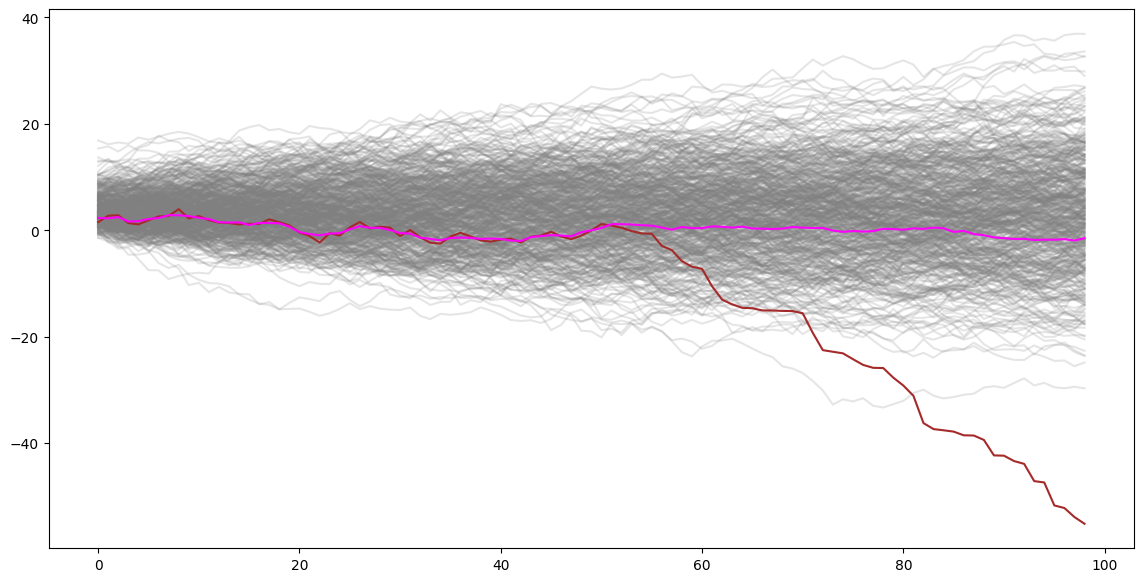

In [ ]:
synth = df.drop(columns='t').dot(weights)
plt.figure(figsize=(14,7))
for column in df.drop('t', axis=1):
    plt.plot(df[column], color='grey', alpha=.2)
# highlight treated unit
plt.plot(df['t'], color='brown')
plt.plot(synth, color='magenta') # the colour is so synthy

As we see above, our naive approach does  decent job at creating a synthetic control for our case. Sadly there is some problems that need to be addressed.

The current implementation does not scale well with sample size:

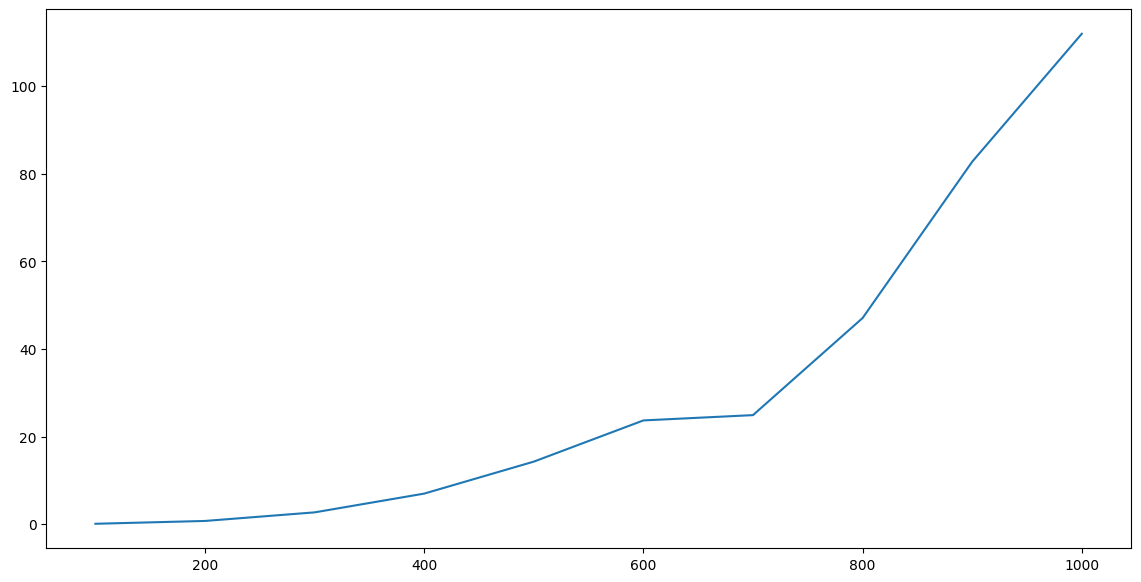

In [12]:
import time

def test_times():
    exec_times = []
    N = []
    for n in range(100,1001):
        if n % 100 == 0:
            tempdf = gen_data(100, n)
            tempdf_T0 = tempdf.loc[:50, :]
            tempY_0 = tempdf_T0['t'].values
            tempY_i = tempdf_T0.drop(columns='t').values
        
            # Now we time it
            start = time.time()
            weights = get_w(tempY_i, tempY_0)
            end = time.time()
            elapsed = end - start
            N.append(n)
            exec_times.append(elapsed)
    plt.figure(figsize=(14,7))
    plt.plot(N, exec_times)

test_times()

As it can seen above, for a sample size of only 1000 cases over 100 time steps (wich could also considered as 10 covariates of 10 steps, very common in social science) take up to 2 minutes, and the execution time grows rather exponentially. For a single synthetic control, this is not a problem, but for individual synthetic controls, in which the analysis could be reapetd hunderds of times, this is not ideal. In a relatively conservative setting with 1000 total cases, and 200 treated unit, finding the weights only could take up to 6 hours. Bootstraping each weigths could take days.

Multiprocessing could help with this problem, but only up to an extent. The most obvious solution is to keep the number of "donor" observation small, and selected them based on some similarity to the treated unit.

In [10]:
from sklearn.neighbors import KDTree
kdt = KDTree(df_T0.T, leaf_size=30, metric='euclidean')
idx = kdt.query(df_T0.T, k=51, return_distance=False)[-1, 1:]
Y_i2 = df_T0.iloc[:, idx]

In [11]:
%time weights2 = get_w(Y_i2, Y_0)
print(weights2.sum())
np.round(weights2, 4)

CPU times: user 145 ms, sys: 4.27 ms, total: 150 ms
Wall time: 146 ms
1.0000000000078868


array([0.2373, 0.1007, 0.    , 0.    , 0.0772, 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.2552, 0.    , 0.0605, 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.029 ,
       0.    , 0.    , 0.    , 0.1542, 0.    , 0.    , 0.    , 0.0859,
       0.    , 0.    ])

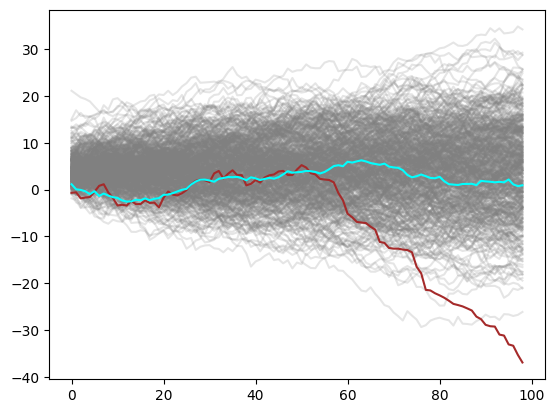

In [12]:
synth = df.iloc[:, idx].dot(weights2) # synthetic control is now based on the new subset of observations
plt.figure()
for column in df.drop('t', axis=1):
    plt.plot(df[column], color='grey', alpha=.2)
# highlight treated unit
plt.plot(df['t'], color='brown')
plt.plot(synth, color='cyan') # another synthy colour

In [13]:
df

,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,...,c492,c493,c494,c495,c496,c497,c498,c499,c500,t
0,5.470810,8.295589,0.226649,2.690660,3.483770,8.308770,4.490271,5.380051,4.405232,2.779355,...,6.634280,3.751600,1.746057,3.574934,1.674460,5.301512,6.615210,7.414847,2.301982,-0.672050
1,3.991753,7.512469,-0.782333,4.415486,3.185023,8.973605,3.860742,4.754698,4.418657,1.486435,...,5.169973,3.337667,1.887664,4.617361,0.606566,5.738875,6.703004,7.031398,3.368452,-0.576232
2,3.659507,8.107816,-0.542200,3.400443,4.986683,9.128748,3.720678,5.092373,3.787557,3.202247,...,4.380179,3.294588,2.223807,5.235258,2.224445,5.136326,7.089610,6.337394,4.929946,-1.863620
3,2.035028,6.944072,-1.839437,4.296220,5.004582,9.884613,4.641485,5.645867,4.324626,3.544284,...,4.598367,3.056910,1.660075,6.068016,2.197859,6.449315,5.714601,7.919528,4.697570,-1.688429
4,1.234787,7.813514,-3.225733,5.167046,5.301972,9.444728,4.136391,4.780167,3.864996,3.208760,...,5.156867,2.970941,2.528002,5.743953,2.351177,5.739602,6.277947,6.070440,5.734994,-1.572719
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,2.438469,7.433340,-4.762693,11.009817,9.787535,5.289173,-12.294238,-2.864558,-4.237350,4.687110,...,-16.375616,-3.612899,-4.411800,28.265928,2.154974,8.833565,12.077284,2.499019,5.325686,-31.190918
95,1.216027,7.154279,-3.777737,9.744318,9.886635,5.752710,-15.152944,-4.181293,-5.115972,4.480115,...,-16.035203,-4.155965,-5.466032,29.463872,1.842439,7.428448,12.634774,3.570072,5.685443,-33.084275
96,0.610840,7.979552,-6.865769,10.633846,9.178321,6.079772,-15.646982,-5.466790,-4.693843,4.622052,...,-17.700288,-3.369107,-6.142493,29.773558,0.831235,6.786566,11.345550,4.445730,7.379009,-33.361802
97,0.825750,9.159736,-7.786272,10.345330,8.590498,6.575486,-16.280512,-5.538598,-7.057251,4.301272,...,-15.799067,-3.266459,-5.952205,28.862808,0.497589,8.029064,11.822141,5.477651,7.834256,-35.305130


By reducing the number of observation used to 50, we get a substantive improvement in speed (from 14 secs to 127 ms, **over 110 times faster**) and very similar results, but how to know what is the optimal number of units to consider? Some inspiration here: https://link.springer.com/article/10.1007/s13209-021-00242-8

## Loading UKHLS data

Here we will load some real data from the UKHLS panel study. We will run a samply test using a single variable and a simple operationalization of the event. In this case, we will take the first intance of care has the main traeatment point. We will allow oly people with with at least 3 data points previous to the event, of a total of 8 data points.

In [14]:
import glob
import os
path = r'/home/daniel/code/costofcare/data/bhp_ukhls_data_stata/UKDA-6614-stata/stata/ukhls'
all_files = glob.glob(os.path.join(path , '*indresp.dta'))
raw_colnames = ['hidp',
                'sex',
                'ethn_dv',
                'dvage',
                'mastat_dv',
                'country',
                'aidhh',
                'aidhrs',
                'aidxhh',
                'fimnlabgrs_dv',
                'fimnlabnet_dv',
                'istrtdatm',
                'istrtdaty']
indresp = []
prefixes = [] # for later
for filename in all_files:
    prefix = filename.split('/')[-1][0:2]
    prefixes.append(prefix)
    colnames = [f'{prefix}{x}' for x in raw_colnames]
    temp_df = pd.read_stata(filename,
                       columns=['pidp'] + colnames)
    indresp.append(temp_df)

In [15]:
cpih = pd.read_csv('./cpih_uk_88_23.csv')
cpih['date'] = pd.to_datetime(cpih.date, format='%b-%y')
dfs_list = []
# This loop is a monstruosity! I need to redo the way I prepare and clean the data.
for i, _ in enumerate(indresp):
    indresp[i][prefixes[i] + 'fimnlabnet_dv'] = pd.to_numeric(indresp[i][prefixes[i] + 'fimnlabnet_dv'], errors='coerce')
    indresp[i][prefixes[i] + 'fimnlabnet_dv'] = indresp[i][prefixes[i] + 'fimnlabnet_dv'].where(indresp[i][prefixes[i] + 'fimnlabnet_dv'] >= 0)
    indresp[i][prefixes[i] + 'fimnlabgrs_dv'] = pd.to_numeric(indresp[i][prefixes[i] + 'fimnlabgrs_dv'], errors='coerce')
    indresp[i][prefixes[i] + 'fimnlabgrs_dv'] = indresp[i][prefixes[i] + 'fimnlabgrs_dv'].where(indresp[i][prefixes[i] + 'fimnlabgrs_dv'] >= 0)
    indresp[i][prefixes[i] + 'istrtdaty'] = indresp[i][prefixes[i] + 'istrtdaty'].replace({'inapplicable': np.nan, 'missing': np.nan, "don't know": np.nan})
    indresp[i][prefixes[i] + 'istrtdatm'] = indresp[i][prefixes[i] + 'istrtdatm'].replace({'inapplicable': np.nan, 'missing': np.nan, "don't know": np.nan})
    indresp[i]['date'] = indresp[i][prefixes[i] + 'istrtdaty'].astype(str)+'/'+indresp[i][prefixes[i] + 'istrtdatm'].astype(str)
    indresp[i]['date'] = indresp[i]['date'].replace({'nan/nan': np.nan})
    indresp[i]['date'] = pd.to_datetime(indresp[i]['date'], format='%Y/%B')
    indresp[i] = indresp[i].merge(cpih, on='date', how='left')
    indresp[i][prefixes[i] + 'wage_gross_cpih_ad'] = (indresp[i][prefixes[i] + 'fimnlabgrs_dv'].astype(float) * 124.8) / indresp[i]['cpih']
    indresp[i][prefixes[i] + 'wage_net_cpih_ad'] = (indresp[i][prefixes[i] + 'fimnlabnet_dv'].astype(float) * 124.8) / indresp[i]['cpih']
    indresp[i] = indresp[i].drop(columns=['date', 'cpih'])

In [16]:
df_netwage = indresp[1]['pidp']
for df in indresp[1:9]:
    for colname in df.columns:
        if 'wage_net_cpih_ad' in colname:
            netwage = colname
            df_netwage = pd.merge(df_netwage, df[['pidp', netwage]], on='pidp', how='left')

In [17]:
df_netwage

,pidp,b_wage_net_cpih_ad,c_wage_net_cpih_ad,d_wage_net_cpih_ad,e_wage_net_cpih_ad,f_wage_net_cpih_ad,g_wage_net_cpih_ad,h_wage_net_cpih_ad,i_wage_net_cpih_ad
0,280165,1435.812432,2119.590025,2700.115129,2810.199396,2786.851862,2748.348348,2774.286837,2660.807656
1,956765,1403.471406,400.585598,NaN,NaN,NaN,NaN,NaN,NaN
2,987365,0.000000,672.581399,NaN,NaN,NaN,NaN,NaN,NaN
3,1114525,3113.508861,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1126765,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
54564,1639072802,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN
54565,1639350882,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
54566,1639350922,1154.432946,NaN,NaN,NaN,NaN,NaN,NaN,NaN
54567,1639350962,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
df_care = indresp[1]['pidp']
for df in indresp[1:9]:
    for colname in df.columns:
        if 'aidxhh' in colname:
            care = colname
            df_care = pd.merge(df_care, df[['pidp', care]], on='pidp', how='left')

In [19]:
df_care = df_care.replace({'Yes': 'yes',
                           'No': 'no',
                           'no     ': 'no',
                           'yes    ': 'yes',
                           'Not available for IEMB': 'no',
                           "don't know": 'no',
                           'proxy': 'no',
                           'missing': np.nan,
                           'refusal': 'no'})

In [20]:
test_data = df_care.merge(df_netwage, on='pidp').dropna()

In [21]:
test_data = test_data.set_index('pidp')

In [22]:
test_data.iloc[:, :8]

,b_aidxhh,c_aidxhh,d_aidxhh,e_aidxhh,f_aidxhh,g_aidxhh,h_aidxhh,i_aidxhh
pidp,,,,,,,,
280165,no,no,no,no,no,no,no,no
1833965,no,no,no,no,no,no,no,no
4454005,no,no,no,no,no,no,no,no
68004087,no,yes,no,no,no,no,no,no
68006127,no,no,no,no,no,no,no,no
...,...,...,...,...,...,...,...,...
1634620727,no,no,no,no,no,no,no,no
1634625487,no,no,no,no,no,no,no,no
1634625491,no,no,no,no,no,no,no,no


In [23]:
idx = (test_data.iloc[:,:3] == 'yes').any(axis=1)
treated = test_data.loc[(test_data['e_aidxhh'] == 'yes') & ~idx] # these are our treated cases!
treated = treated.iloc[:, 8:].reset_index(drop=True)
treated.columns = [0, 1, 2, 3, 4, 5, 6, 7]

<Axes: >

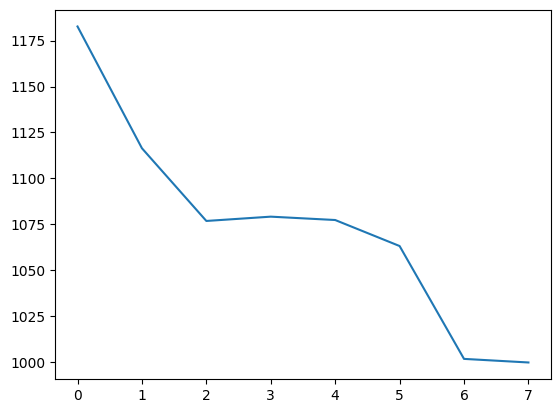

In [24]:
treated.mean().plot()

In [25]:
control = test_data[~(test_data.iloc[:,:8] == 'yes').any(axis=1)] # this is our control group
control = control.iloc[:, 8:].reset_index(drop=True)
control.columns = [0, 1, 2, 3, 4, 5, 6, 7]

<Axes: >

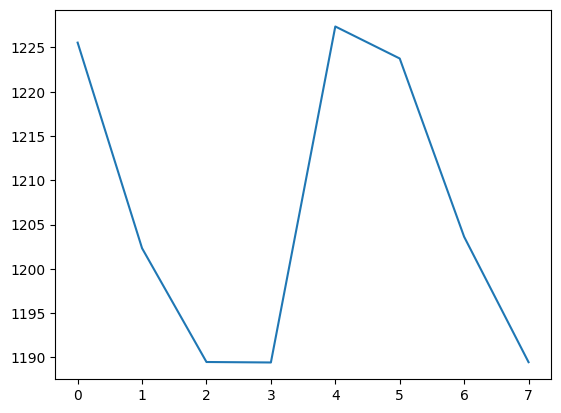

In [26]:
control.mean().plot()

## ISC on real data

### Lets separate the datasets between before and after treatment

In [27]:
from sklearn.neighbors import KDTree
control_T0 = control.iloc[:, :3].T
treated_T0 = treated.iloc[:, :3].T

In [28]:
treated_T0

,0,1,2,3,4,5,6,7,8,9,...,621,622,623,624,625,626,627,628,629,630
0,2524.044944,0.0,1264.864865,1032.972973,1272.833489,1264.826966,0.0,0.0,2049.081081,978.305774,...,1120.590675,1844.456990,2282.021379,0.0,0.0,628.889197,0.0,0.0,626.193870,1795.96036
1,2569.014085,0.0,1222.169935,993.777778,1231.237624,1347.732181,0.0,0.0,1892.957746,1132.770706,...,515.874298,1781.830975,2187.216495,0.0,0.0,833.710175,0.0,0.0,1026.416327,0.00000
2,2603.270440,0.0,1210.062893,1012.105597,1831.014900,1302.656934,0.0,0.0,1700.628931,1142.994990,...,530.746332,318.221031,2275.987842,0.0,0.0,695.440729,0.0,0.0,763.229978,0.00000


In [29]:
synth_controls = []
for col in treated_T0:
    Ti = pd.concat([treated.T[col], control.T], axis=1)
    T0 = pd.concat([treated_T0[col], control_T0], axis=1)
    T0 = T0.reset_index(drop=True)
    kdt = KDTree(T0.T, leaf_size=30, metric='euclidean')
    idx = kdt.query(T0.T, k=51, return_distance=False)[0, 1:] # first item and the list does not contain itself
    Y_i3 = T0.iloc[:, idx]
    weights3 = get_w(Y_i3, treated_T0[col])
    synth = Ti.iloc[:, idx].dot(weights3)
    synth_controls.append(synth)

In [30]:
synths = pd.DataFrame(synth_controls).T

# Tadaaaaa?

Text(0, 0.5, 'Average Net Income (inflation corrected) in GBPs')

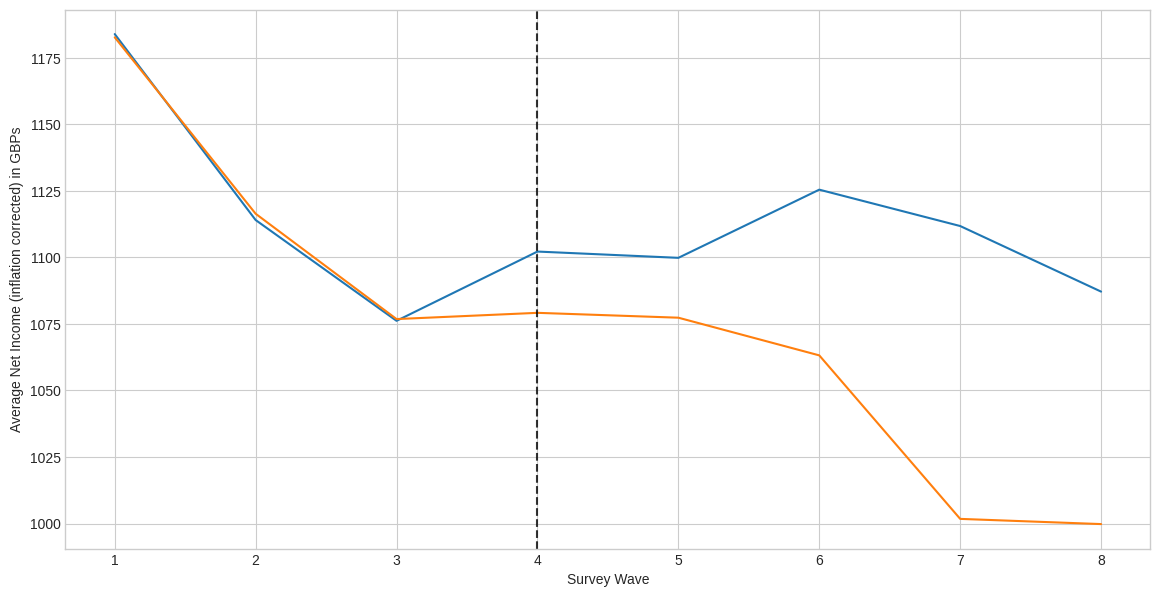

In [31]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 7))
plt.style.use('seaborn-v0_8-whitegrid')
ax1 = synths.T.mean().plot()
ax2 = treated.mean().plot()
plt.axvline(x=3, linestyle='--', color='black', alpha=.8)
plt.xticks(ticks=[0, 1, 2, 3, 4, 5, 6, 7], labels=[1, 2, 3, 4, 5, 6, 7, 8])
plt.xlabel('Survey Wave')
plt.ylabel('Average Net Income (inflation corrected) in GBPs')

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

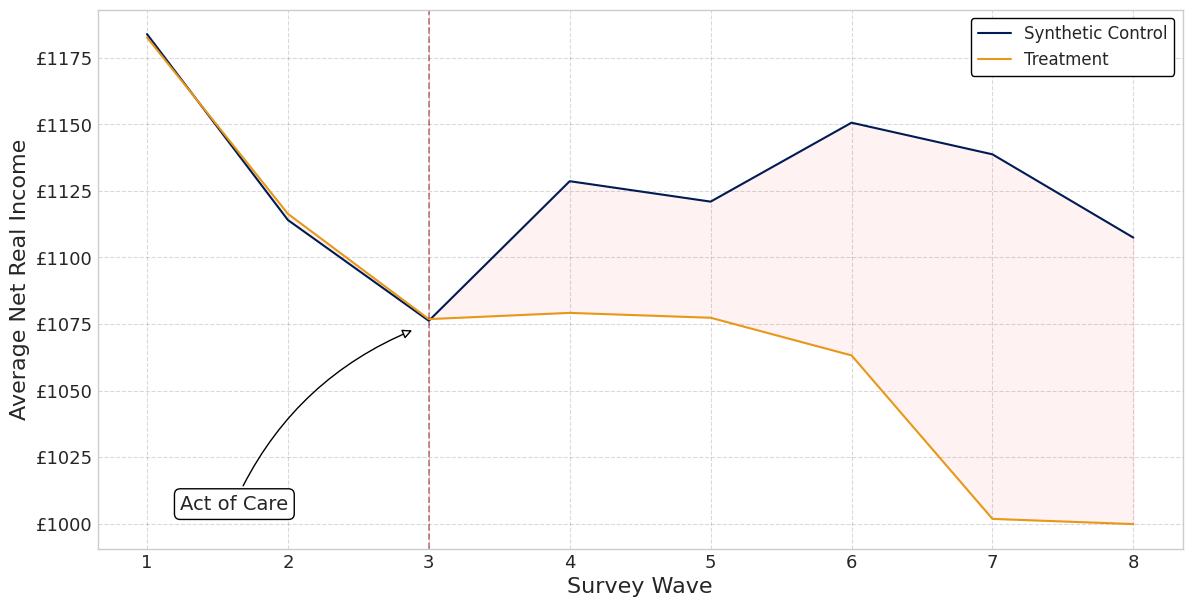

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mtick

mpl.rc('font', family='Helvetica')
df = pd.DataFrame(index=[1, 2, 3, 4, 5, 6, 7, 8], columns = ['Synthetic Control', 'Treatment'])
df['Treatment'] = [1182.707637, 1116.416396, 1076.837222, 1079.179123,
                   1077.349768, 1063.191094, 1001.751372, 999.797263]
df['Synthetic Control'] = [1183.959820, 1114.082180, 1076.213701, 1128.670642,
                           1120.990367, 1150.659503, 1138.766639, 1107.469253]
ax = df.plot(figsize=(14, 7), color = ['#001c54', '#E89818'])
ax.grid(linestyle='--', color='k', alpha=0.15, zorder=0)
plt.axvline(x=3, linestyle='--', color='darkred', alpha=.5, linewidth=1.25)
plt.xlabel('Survey Wave', fontsize=16)
plt.ylabel('Average Net Real Income', fontsize=16)
fmt = '£%.0f'
tick = mtick.FormatStrFormatter(fmt)
ax.yaxis.set_major_formatter(tick)
ax.tick_params(axis='both', which='major', labelsize=13)
ax.legend(loc='upper right', frameon=True,
          fontsize=12, framealpha=1, facecolor='w',
          edgecolor=(0, 0, 0, 1),
          )
ann = ax.annotate("Act of Care",
                  xy=(2.9, 1073), xycoords='data',
                  xytext=(1.62, 1007.3), textcoords='data',
                  size=14, va="center", ha="center",
                  bbox=dict(boxstyle="round", fc="w"),
                  arrowprops=dict(arrowstyle="-|>", linestyle='-',
                                  connectionstyle="arc3,rad=-0.2",
                                  fc="w"))
plt.fill_between(df['Treatment'].index, df['Treatment'], y2=df['Synthetic Control'],
                     color='red', alpha=0.05)
plt.show()